**mport libraries used in the analysis.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

****Load dataset**

In [2]:
# Load data
df = pd.read_csv("click_rates.csv")
print("Dataset Loaded:")
print(df.head())

Dataset Loaded:
     Headline     Click  Rate
0  Headline A     Click    14
1  Headline A  No-click   986
2  Headline B     Click     8
3  Headline B  No-click   992
4  Headline C     Click    12


**Data cleaning & preparation**
add helper column is_click and aggregate counts per headline.

In [3]:
df["is_click"] = df["Click"].apply(lambda x: 1 if str(x).lower()=="click" else 0)

summary = df.groupby("Headline").agg(
    clicks = ("Rate", lambda x: x[df["Click"]=="Click"].sum()),
    no_clicks = ("Rate", lambda x: x[df["Click"]=="No-click"].sum())
)

summary["total"] = summary["clicks"] + summary["no_clicks"]
summary["CTR"] = summary["clicks"] / summary["total"]

print("\n=== CTR SUMMARY ===")
print(summary)



=== CTR SUMMARY ===
            clicks  no_clicks  total    CTR
Headline                                   
Headline A      14        986   1000  0.014
Headline B       8        992   1000  0.008
Headline C      12        988   1000  0.012


**Visualize: Bar chart (CTR per Headline)**
plot CTR for each headline.

/tmp/ipykernel_5092/74881336.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y=summary["CTR"], palette="Blues")


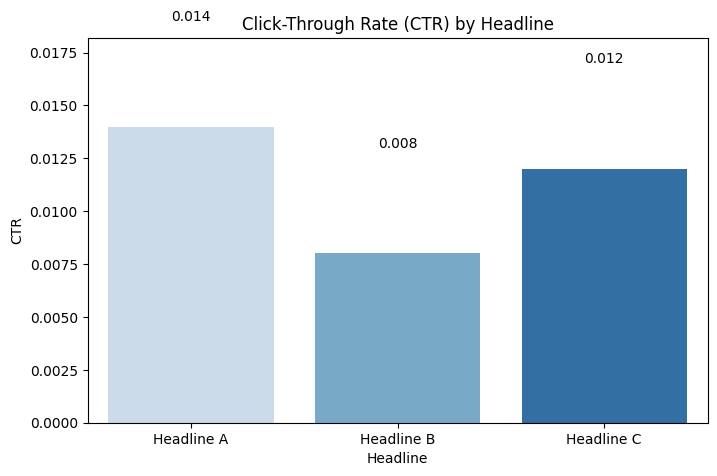

In [4]:
plt.figure(figsize=(8,5))
sns.barplot(x=summary.index, y=summary["CTR"], palette="Blues")
plt.title("Click-Through Rate (CTR) by Headline")
plt.ylabel("CTR")
plt.xlabel("Headline")
plt.ylim(0, summary["CTR"].max() * 1.3)
for i, v in enumerate(summary["CTR"]):
    plt.text(i, v+0.005, f"{v:.3f}", ha="center")
plt.show()

**Statistical test: Chi-square test (Are click rates different across headlines)**
use chi-square on the contingency table of clicks/no-clicks.

In [5]:
chi_data = summary[["clicks", "no_clicks"]].values
chi2, p, dof, expected = chi2_contingency(chi_data)
print("\n=== CHI-SQUARE TEST ===")
print(f"Chi-square = {chi2:.4f}")
print(f"P-value = {p:.6f}")
print("Conclusion:", "SIGNIFICANT difference" if p<0.05 else "No significant difference")


=== CHI-SQUARE TEST ===
Chi-square = 1.6659
P-value = 0.434756
Conclusion: No significant difference


**pairwise A/B tests: Proportion Z-tests**
pairwise compare headlines using two-sample z-test for proportions.

In [6]:
print("\n=== PROPORTION Z-TESTS (A/B Tests) ===")
headlines = summary.index.tolist()
for i in range(len(headlines)):
    for j in range(i+1, len(headlines)):
        A = headlines[i]; B = headlines[j]
        clicks = [int(summary.loc[A,"clicks"]), int(summary.loc[B,"clicks"])]
        totals = [int(summary.loc[A,"total"]), int(summary.loc[B,"total"])]
        z, p_val = proportions_ztest(clicks, totals)
        print(f"\n{A} vs {B}")
        print(f"Z = {z:.4f}, p = {p_val:.6f} →", "SIGNIFICANT" if p_val<0.05 else "Not significant")



=== PROPORTION Z-TESTS (A/B Tests) ===

Headline A vs Headline B
Z = 1.2863, p = 0.198339 → Not significant

Headline A vs Headline C
Z = 0.3948, p = 0.692985 → Not significant

Headline B vs Headline C
Z = -0.8989, p = 0.368688 → Not significant


**Heatmap: Clicks vs No-clicks**

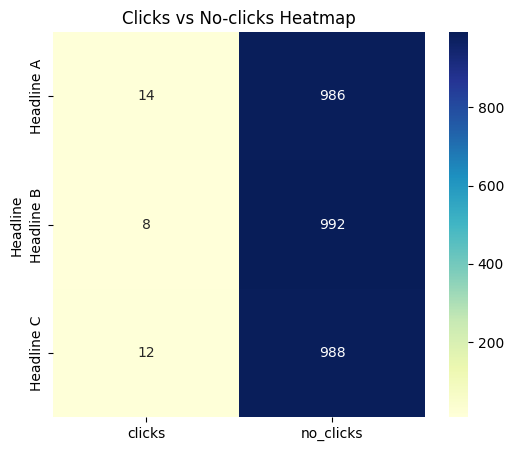

In [7]:
plt.figure(figsize=(6,5))
sns.heatmap(summary[["clicks","no_clicks"]], annot=True, fmt="d", cmap="YlGnBu")
plt.title("Clicks vs No-clicks Heatmap")
plt.show()
